In [ ]:
# Install nnUNet and dependencies
!pip install -q git+https://github.com/MIC-DKFZ/nnUNet.git
!apt-get install -y libglib2.0-0 libsm6 libxrender-dev libxext6
!pip install -q SimpleITK


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()


Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os


os.environ['nnUNet_raw'] = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data'
os.environ['nnUNet_preprocessed'] = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_preprocessed'
os.environ['nnUNet_results'] = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_results'


os.makedirs(os.environ["nnUNet_raw"], exist_ok=True)
os.makedirs(os.environ["nnUNet_preprocessed"], exist_ok=True)
os.makedirs(os.environ["nnUNet_results"], exist_ok=True)


###Ensure images and masks are paired and matched

In [ ]:
def count_tif_files(input_folder):
    files = os.listdir(input_folder)
    tif_files = [f for f in files if f.endswith('.tif')]
    return len(tif_files)

# Example usage:
tif_image_folder_path = '/content/drive/MyDrive/dataset/images'
tif_count = count_tif_files(tif_image_folder_path)
print(f"Number of .tif images: {tif_count}")


Number of .tif images: 3929


In [ ]:
def count_tif_files(input_folder):
    files = os.listdir(input_folder)
    tif_files = [f for f in files if f.endswith('.tif')]
    return len(tif_files)

# Example usage:
tif_masks_folder_path = '/content/drive/MyDrive/dataset/masks'
tif_count = count_tif_files(tif_masks_folder_path)
print(f"Number of .tif masks: {tif_count}")

Number of .tif masks: 3929


###Split the folders into train and test
Create an images_test and images_masks folders

In [ ]:
import os
import shutil
import random

def split_image_mask_dataset(image_dir, mask_dir, output_dir, test_ratio=0.2, seed=42):
    random.seed(seed)

    # Ensure output subdirectories exist
    subsets = ['training', 'testing']
    for subset in subsets:
        os.makedirs(os.path.join(output_dir, f'images_{subset}'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, f'labels_{subset}'), exist_ok=True)

    # Collect IDs from image filenames (e.g., 1_image.tif → 1)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.tif', '.tiff')) and '_image' in f]
    ids = [f.split('_')[0] for f in image_files]

    # Shuffle and split IDs
    random.shuffle(ids)
    split_index = int(len(ids) * (1 - test_ratio))
    train_ids = ids[:split_index]
    test_ids = ids[split_index:]

    def copy_pair(id_, subset):
        img_filename = f"{id_}_image.tif"
        mask_filename = f"{id_}_mask.tif"

        src_img = os.path.join(image_dir, img_filename)
        src_mask = os.path.join(mask_dir, mask_filename)

        dst_img = os.path.join(output_dir, f'images_{subset}', img_filename)
        dst_mask = os.path.join(output_dir, f'labels_{subset}', mask_filename)

        if os.path.exists(src_img) and os.path.exists(src_mask):
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_mask, dst_mask)
        else:
            print(f"⚠️ Warning: Missing image or mask for ID {id_}")

    # Copy files
    for id_ in train_ids:
        copy_pair(id_, 'training')
    for id_ in test_ids:
        copy_pair(id_, 'testing')

    print(f"✅ Done! {len(train_ids)} training and {len(test_ids)} testing image–mask pairs saved.")

# 🧪 Example usage
split_image_mask_dataset(
    image_dir="/content/drive/MyDrive/dataset/images",
    mask_dir="/content/drive/MyDrive/dataset/masks",
    output_dir="/content/drive/MyDrive/split_dataset",
    test_ratio=0.2
)


✅ Done! 3143 training and 786 testing image–mask pairs saved.


###Checking if it's a coloured image, then separating them into Red, Green and Blue to work for nnunet

why?
If you combine the channels into one image:
nnU-Net won’t know how to split or interpret them.

It will treat it as a single-channel image, and you'll lose the benefits of using RGB (or multi-modal) inputs.

TypeError: Invalid shape (256,) for image data

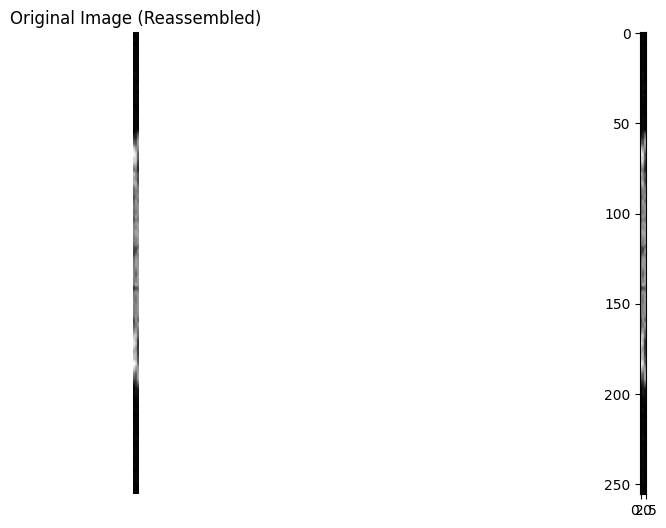

In [ ]:
import os
import tifffile as tiff
import SimpleITK as sitk
import re

def convert_tif_to_nnunet_batch(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    tif_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.tif', '.tiff'))]

    for filename in tif_files:
        image_path = os.path.join(input_folder, filename)

        # Extract the numeric patient ID from the filename (e.g. 3652 from 3652_image.tif)
        match = re.search(r'\d+', filename)
        if not match:
            print(f"{filename}: No numeric ID found, skipping.")
            continue
        patient_number = int(match.group())
        patient_id = f"patient{patient_number:04d}"

        img = tiff.imread(image_path)

        if len(img.shape) == 2:  # Grayscale
            sitk_img = sitk.GetImageFromArray(img)
            sitk.WriteImage(sitk_img, os.path.join(output_folder, f"{patient_id}_0000.nii.gz"))
            print(f"{filename}: Saved grayscale as {patient_id}_0000.nii.gz")

        elif len(img.shape) == 3:
            for ch in range(img.shape[-1]):  # Iterate through each RGB channel
                channel = img[..., ch]
                sitk_img = sitk.GetImageFromArray(channel)
                sitk.WriteImage(sitk_img, os.path.join(output_folder, f"{patient_id}_000{ch}.nii.gz"))
            print(f"{filename}: Saved RGB channels as {patient_id}_0000, {patient_id}_0001, {patient_id}_0002.nii.gz")

        else:
            print(f"{filename}: Unsupported shape {img.shape}")

# Example usage for images_training
input_image_folder_train = "/content/drive/MyDrive/split_dataset/images_training"
output_image_folder_train = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr"
convert_tif_to_nnunet_batch(input_image_folder_train, output_image_folder_train)


In [ ]:
# Example usage for images_testing
input_image_folder_test = "/content/drive/MyDrive/split_dataset/images_testing"
output_image_folder_test = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTs"
convert_tif_to_nnunet_batch(input_image_folder_test, output_image_folder_test)


3069_image.tif: Saved RGB channels as patient3069_0000, patient3069_0001, patient3069_0002.nii.gz
283_image.tif: Saved RGB channels as patient0283_0000, patient0283_0001, patient0283_0002.nii.gz
97_image.tif: Saved RGB channels as patient0097_0000, patient0097_0001, patient0097_0002.nii.gz
2873_image.tif: Saved RGB channels as patient2873_0000, patient2873_0001, patient2873_0002.nii.gz
2683_image.tif: Saved RGB channels as patient2683_0000, patient2683_0001, patient2683_0002.nii.gz
405_image.tif: Saved RGB channels as patient0405_0000, patient0405_0001, patient0405_0002.nii.gz
3462_image.tif: Saved RGB channels as patient3462_0000, patient3462_0001, patient3462_0002.nii.gz
2834_image.tif: Saved RGB channels as patient2834_0000, patient2834_0001, patient2834_0002.nii.gz
996_image.tif: Saved RGB channels as patient0996_0000, patient0996_0001, patient0996_0002.nii.gz
2352_image.tif: Saved RGB channels as patient2352_0000, patient2352_0001, patient2352_0002.nii.gz
3632_image.tif: Saved RGB

check the number of images in the images folder. It should be 3929 *3 =11787

In [ ]:
import os

def count_images_in_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter the files to count only .nii.gz files
    nii_files = [f for f in files if f.endswith('.nii.gz')]

    return len(nii_files)

# Example usage:
output_image_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr'
image_count = count_images_in_folder(output_image_folder)
print(f"Number of .nii.gz images in the folder: {image_count}")


Number of .nii.gz images in the folder: 9429


Display images after separating green red and blue

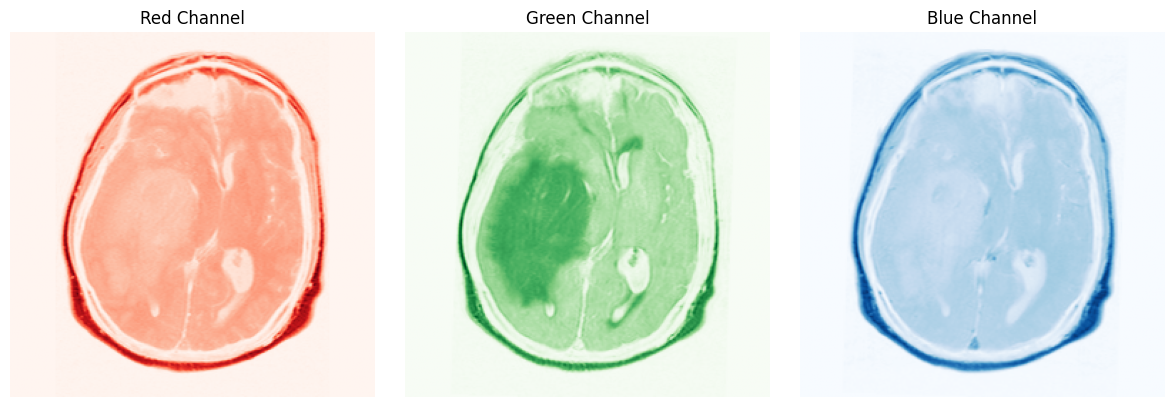

In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

def show_patient_rgb_images(folder, patient_id="patient001"):
    red_path = f"{folder}/{patient_id}_0000.nii.gz"
    green_path = f"{folder}/{patient_id}_0001.nii.gz"
    blue_path = f"{folder}/{patient_id}_0002.nii.gz"

    red = sitk.GetArrayFromImage(sitk.ReadImage(red_path))
    green = sitk.GetArrayFromImage(sitk.ReadImage(green_path))
    blue = sitk.GetArrayFromImage(sitk.ReadImage(blue_path))

    # Plot each channel
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(red, cmap='Reds')
    axs[0].set_title('Red Channel')
    axs[1].imshow(green, cmap='Greens')
    axs[1].set_title('Green Channel')
    axs[2].imshow(blue, cmap='Blues')
    axs[2].set_title('Blue Channel')

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
show_patient_rgb_images(output_image_folder, patient_id="patient0066")


Do the same for the mask. rename it and convert fron tif to nii.gz to allow unnet easily identify it

In [ ]:
import os
import tifffile as tiff
import SimpleITK as sitk

def convert_all_binary_labels_to_nnunet(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith((".tif", ".tiff")) and "_mask" in filename:
            label_path = os.path.join(input_dir, filename)
            label_img = tiff.imread(label_path)

            if len(label_img.shape) != 2:
                print(f"Skipping {filename}: Not a 2D grayscale image.")
                continue

            # Binarize (ensure values are 0 or 1)
            label_img = (label_img > 0).astype("uint8")

            # Extract and format patient ID (e.g., '1' → '0001')
            patient_id_raw = filename.split('_')[0]
            patient_id = f"patient{int(patient_id_raw):04d}"
            output_filename = os.path.join(output_dir, f"{patient_id}.nii.gz")

            # Convert to SimpleITK and save
            sitk_img = sitk.GetImageFromArray(label_img)
            sitk.WriteImage(sitk_img, output_filename)
            print(f"Saved: {output_filename}")

# Example usage for training labels
input_mask_folder_train = "/content/drive/MyDrive/split_dataset/labels_training"
output_mask_folder_train = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr"
convert_all_binary_labels_to_nnunet(input_mask_folder_train, output_mask_folder_train)


Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient1831.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient2928.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient2245.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient2876.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient3809.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient0382.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient2957.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient1695.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_d

In [ ]:
# Example usage for testing labels
input_mask_folder_test = "/content/drive/MyDrive/split_dataset/labels_testing"
output_mask_folder_test = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs"
convert_all_binary_labels_to_nnunet(input_mask_folder_test, output_mask_folder_test)


Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient3069.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient0283.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient0097.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient2873.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient2683.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient0405.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient3462.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient2834.nii.gz
Saved: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_d

Check the number of segmentation images you have. To be sure it's still the same as when it was tif format


In [ ]:
import os

def count_images_in_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter the files to count only .nii.gz files
    nii_files = [f for f in files if f.endswith('.nii.gz')]

    return len(nii_files)

# Example usage:
output_mask_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr'
label_count = count_images_in_folder(output_mask_folder)
print(f"Number of .nii.gz labels in the folder: {label_count}")

Number of .nii.gz labels in the folder: 3143


Great! the number is the same.
You may be wondering how the nnUnet model will work with 3times the number of masks as images.

Well, nnU-Net matches samples using the patient ID prefix. So for:

Image: patient001_0000.nii.gz, patient001_0001.nii.gz, patient001_0002.nii.gz

Label: patient001.nii.gz

It sees these all as belonging to one case: patient001.

nnU-Net interprets the multiple _000X.nii.gz files as input channels (e.g., RGB), and expects a single label mask per patient

###Phase2
Now that we have made it the right format, we will creat out json file

In [ ]:
# # First, uninstall any existing nnUNet package if it was incorrectly installed
# !pip uninstall -y nnunet

# # Install nnUNet v2 correctly
# !pip install git+https://github.com/MIC-DKFZ/nnUNet.git@master


  Cloning https://github.com/MIC-DKFZ/nnUNet.git (to revision master) to /tmp/pip-req-build-791hsztr
  Running command git clone --filter=blob:none --quiet https://github.com/MIC-DKFZ/nnUNet.git /tmp/pip-req-build-791hsztr
  Resolved https://github.com/MIC-DKFZ/nnUNet.git to commit 58a3b121a6d1846a978306f6c79a7c005b7d669b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
!pip install git+https://github.com/MIC-DKFZ/nnUNet.git


  Cloning https://github.com/MIC-DKFZ/nnUNet.git to /tmp/pip-req-build-mrihk0jf
  Running command git clone --filter=blob:none --quiet https://github.com/MIC-DKFZ/nnUNet.git /tmp/pip-req-build-mrihk0jf
  Resolved https://github.com/MIC-DKFZ/nnUNet.git to commit 58a3b121a6d1846a978306f6c79a7c005b7d669b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import os
from nnunetv2.dataset_conversion.generate_dataset_json import generate_dataset_json

# Define paths
output_folder = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask"

# Channel map for RGB images
channel_names = {
    0: "Red",
    1: "Green",
    2: "Blue"
}

# Labels (optional — you can skip this if nnU-Net defaults are fine)
labels = {
    "background": 0,
    "tumor": 1
}

# Count patients by unique ID (each has 3 channel files)
num_training_cases = len(os.listdir(os.path.join(output_folder, "imagesTr"))) // 3

# Dataset name and file format
dataset_name = "MySegTask"
file_ending = ".nii.gz"

# Generate the JSON file
generate_dataset_json(
    output_folder=output_folder,
    channel_names=channel_names,
    labels=labels,
    num_training_cases=num_training_cases,
    file_ending=file_ending,
    dataset_name=dataset_name,
    description="My segmentation task dataset using RGB channels from TIFF",
    license="CC-BY-SA 4.0",
    reference="Converted from custom TIFF RGB dataset",
    release="1.0",
    converted_by="Olamide Ajayi"
)


In [ ]:
!ls /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask


dataset.json  imagesTr	imagesTs  labelsTr  labelsTs


###Preprocess the data
this will:

Analyze your dataset

Create preprocessing plans

Normalize, crop, and resample as needed

Generate preprocessed data in nnUNet_preprocessed/



In [ ]:
!nnUNetv2_plan_and_preprocess -d 1


Fingerprint extraction...
Dataset001_MySegTask
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 3143/3143 [13:47<00:00,  3.80it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 49, 'patch_size': (np.int64(256), np.int64(256)), 'median_image_size_in_voxels': array([255., 256.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization', 'ZScoreNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False, False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwa

###Train the Model

In [ ]:
!cp /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_results/Dataset001_MySegTask/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_best.pth \
   /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_results/Dataset001_MySegTask/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_latest.pth


In [ ]:
!nnUNetv2_train 1 2d 0



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-05-02 00:49:58.156849: Using torch.compile...
2025-05-02 00:50:37.358116: do_dummy_2d_data_aug: False
2025-05-02 00:50:37.481114: Using splits from existing split file: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_preprocessed/Dataset001_MySegTask/splits_final.json
2025-05-02 00:50:3

###Prediction Time!

In [ ]:
import os

# Define the path to the predictions folder
predictions_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/predictions'

# Create the folder if it doesn't already exist
os.makedirs(predictions_folder, exist_ok=True)

print(f"Predictions folder created at: {predictions_folder}")


Predictions folder created at: /content/drive/MyDrive/Brain_seg/nnUNet_data/predictions


In [ ]:
!nnUNetv2_predict \
  -i /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTs \
  -o /content/drive/MyDrive/Brain_seg/nnUNet_data/predictions \
  -d Dataset001_MySegTask \
  -tr nnUNetTrainer \
  -c 2d \
  -f 0\
  #-chk checkpoint_best.pth




#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 786 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 786 cases that I would like to predict

Predicting patient0014:
perform_everything_on_device: True
100% 1/1 [00:01<00:00,  1.11s/it]
sending off prediction to background worker for resampling and export
done with patient0014

Predicting patient0025:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 19.68it/s]
sending off prediction to background worker for resampling and export
done with patient0025

Predicting patient0030:
perform_everything_on_device: True
10

Explanation:

-i: Input folder for the test images (imagesTs).

-o: Output folder for saving the predictions.

-d: Dataset name or ID (you’ve already defined Dataset001_MySegTask).

-c: Configuration used for the model (2d).

-f: Fold number (0 for the first fold).

-tr is just for the trainer class name, which should be:

###Evaluation Time

In [ ]:
!nnUNetv2_evaluate_folder \
  /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs \
  /content/drive/MyDrive/Brain_seg/nnUNet_data/predictions \
  -djfile /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/dataset.json \
  -pfile /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_results/Dataset001_MySegTask/nnUNetTrainer__nnUNetPlans__2d/plans.json


Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer


Ground truth array shape: (256, 256)
Prediction array shape: (256, 256)


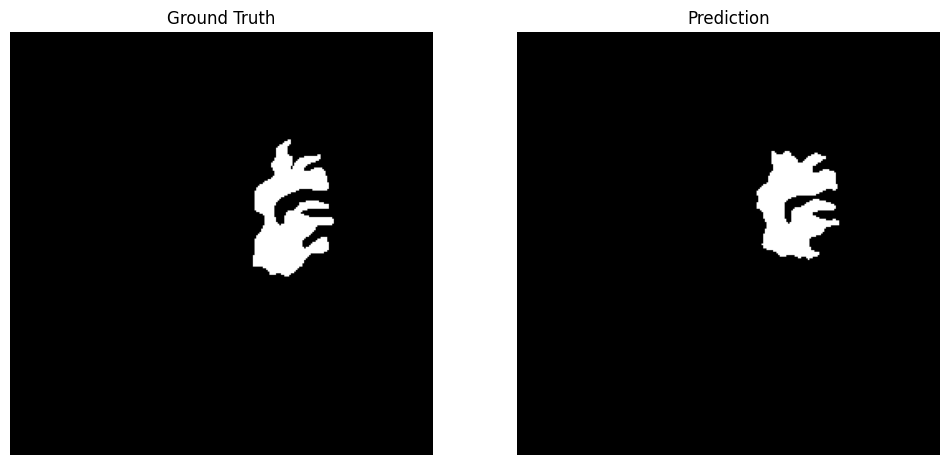

In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Load the prediction and ground truth NIfTI files
gt_path = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs/patient1182.nii.gz'  # Ground truth path
pred_path = '/content/drive/MyDrive/Brain_seg/nnUNet_data/predictions/patient1182.nii.gz'  # Prediction path

gt_img = sitk.ReadImage(gt_path)
pred_img = sitk.ReadImage(pred_path)

# Convert to numpy arrays for visualization
gt_array = sitk.GetArrayFromImage(gt_img)
pred_array = sitk.GetArrayFromImage(pred_img)

# Print the shape of the arrays to understand their structure
print("Ground truth array shape:", gt_array.shape)
print("Prediction array shape:", pred_array.shape)

# Visualize slices (since the data is 2D, no need for slice_idx)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Directly display the entire 2D slice (no need for indexing as it's already 2D)
axes[0].imshow(gt_array, cmap='gray')
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(pred_array, cmap='gray')
axes[1].set_title('Prediction')
axes[1].axis('off')

plt.show()


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to calculate Dice score (for segmentation tasks)
def dice_score(y_true, y_pred):
    smooth = 1e-5  # Smoothing term to avoid division by zero
    intersection = np.sum(y_true * y_pred)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Function to calculate IoU (Intersection over Union) score
def iou_score(y_true, y_pred):
    smooth = 1e-5
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + smooth)

# Function to calculate Sensitivity (True Positive Rate)
def sensitivity(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# Function to calculate Specificity (True Negative Rate)
def specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Evaluate the dataset
def evaluate_dataset(gt_folder, pred_folder):
    gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith('.nii.gz')])  # Ground truth files
    pred_files = sorted([f for f in os.listdir(pred_folder) if f.endswith('.nii.gz')])  # Prediction files

    dice_scores = []
    iou_scores = []
    sensitivities = []
    specificities = []
    accuracies = []

    # Loop over all files
    for gt_file, pred_file in zip(gt_files, pred_files):
        gt_path = os.path.join(gt_folder, gt_file)
        pred_path = os.path.join(pred_folder, pred_file)

        # Load ground truth and prediction images
        gt_img = sitk.ReadImage(gt_path)
        pred_img = sitk.ReadImage(pred_path)

        # Convert to numpy arrays for comparison
        gt_array = sitk.GetArrayFromImage(gt_img).astype(np.uint8)
        pred_array = sitk.GetArrayFromImage(pred_img).astype(np.uint8)

        # Flatten the arrays for accuracy computation
        gt_flat = gt_array.flatten()
        pred_flat = pred_array.flatten()

        # Compute accuracy
        accuracy = accuracy_score(gt_flat, pred_flat)
        accuracies.append(accuracy)

        # Compute Dice score
        dice = dice_score(gt_array, pred_array)
        dice_scores.append(dice)

        # Compute IoU score
        iou = iou_score(gt_array, pred_array)
        iou_scores.append(iou)

        # Compute Sensitivity
        sens = sensitivity(gt_array, pred_array)
        sensitivities.append(sens)

        # Compute Specificity
        spec = specificity(gt_array, pred_array)
        specificities.append(spec)

    # Calculate the average scores across all images
    avg_accuracy = np.mean(accuracies)
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    # Print results
    print(f"Accuracy: {avg_accuracy:.4f}")
    print(f"Dice Coefficient: {avg_dice:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Sensitivity: {avg_sensitivity:.4f}")
    print(f"Specificity: {avg_specificity:.4f}")

# Paths to the ground truth and prediction folders
gt_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTs'
pred_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/predictions'

# Run the evaluation
evaluate_dataset(gt_folder, pred_folder)


Accuracy: 0.9982
Dice Coefficient: 0.2980
IoU: 0.2717
Sensitivity: 0.2982
Specificity: 0.9992


#**STOP**

In [ ]:
import SimpleITK as sitk
import os
import numpy as np

img_dir = "/content/drive/MyDrive/dataset/images"
mask_dir = "/content/drive/MyDrive/dataset/masks"

out_img_dir = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr"
out_mask_dir = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr"

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

for i in range(1, 3930):
    img_path = os.path.join(img_dir, f"{i}_image.tif")
    mask_path = os.path.join(mask_dir, f"{i}_mask.tif")

    if os.path.exists(img_path) and os.path.exists(mask_path):
        # Load image and mask
        img = sitk.ReadImage(img_path)
        mask = sitk.ReadImage(mask_path)

        # Check if dimensions match; if not, upgrade mask to 3D
        if mask.GetDimension() != img.GetDimension():
            mask_array = sitk.GetArrayFromImage(mask)
            mask_array = np.expand_dims(mask_array, axis=0)  # make it [1, H, W]
            mask = sitk.GetImageFromArray(mask_array)

        # Match size, spacing, etc.
        mask.SetSpacing(img.GetSpacing())
        mask.SetOrigin(img.GetOrigin())
        mask.SetDirection(img.GetDirection())

        # Save in nnUNet naming format
        sitk.WriteImage(img, os.path.join(out_img_dir, f"{i:04d}_0000.nii.gz"))
        sitk.WriteImage(mask, os.path.join(out_mask_dir, f"{i:04d}.nii.gz"))


Converted and saved: 3640_image.tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3640_image.nii.gz
Converted and saved: 3639_image (1).tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3639_image (1).nii.gz
Converted and saved: 3654_image.tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3654_image.nii.gz
Converted and saved: 3661_image.tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3661_image.nii.gz
Converted and saved: 3649_image (1).tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3649_image (1).nii.gz
Converted and saved: 3639_image.tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3639_image.nii.gz
Converted and saved: 3651_image.tif -> /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_d

KeyboardInterrupt: 

In [ ]:
# import SimpleITK as sitk

# # Load the NIfTI images to check
# image = sitk.ReadImage("/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/3929_0000.nii.gz")
# mask = sitk.ReadImage("/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/3929.nii.gz")

# # Convert them to numpy arrays to inspect
# image_array = sitk.GetArrayFromImage(image)
# mask_array = sitk.GetArrayFromImage(mask)

# # Check the shape and some info
# print(f"Image shape: {image_array.shape}")
# print(f"Mask shape: {mask_array.shape}")


Image shape: (256, 256, 3)
Mask shape: (256, 256)


convert images to grat scale

In [ ]:
# import cv2
# import numpy as np
# import os
# import SimpleITK as sitk

# def save_as_nifti(image_array, output_path):
#     """
#     Save the numpy array as a NIfTI file (.nii.gz).
#     If the file already exists, it will be overwritten.
#     """
#     itk_image = sitk.GetImageFromArray(image_array)
#     sitk.WriteImage(itk_image, output_path)

# def process_images_in_folder(input_folder, output_folder):
#     os.makedirs(output_folder, exist_ok=True)

#     tif_files = [f for f in os.listdir(input_folder) if f.endswith(".tif")]
#     tif_files.sort()  # Ensure consistent ordering

#     for idx, filename in enumerate(tif_files):
#         image_path = os.path.join(input_folder, filename)
#         # nnUNet requires _0000 for the modality
#         output_filename = f"patient_{idx:04d}_0000.nii.gz"
#         output_path = os.path.join(output_folder, output_filename)

#         image_rgb = cv2.imread(image_path)
#         image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
#         image_gray = np.expand_dims(image_gray, axis=-1)

#         save_as_nifti(image_gray, output_path)
#         print(f"Saved image: {output_path}")

# def process_masks_in_folder(input_folder, output_folder):
#     os.makedirs(output_folder, exist_ok=True)

#     tif_files = [f for f in os.listdir(input_folder) if f.endswith(".tif")]
#     tif_files.sort()  # Ensure consistent ordering

#     for idx, filename in enumerate(tif_files):
#         mask_path = os.path.join(input_folder, filename)
#         output_filename = f"patient_{idx:04d}.nii.gz"
#         output_path = os.path.join(output_folder, output_filename)

#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         save_as_nifti(mask, output_path)
#         print(f"Saved mask: {output_path}")

# # Directories for images and masks
# img_dir = "/content/drive/MyDrive/dataset/images"
# mask_dir = "/content/drive/MyDrive/dataset/masks"

# # Output directories for processed images and masks
# out_img_dir = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr"
# out_mask_dir = "/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr"

# # Process all images and masks
# process_images_in_folder(img_dir, out_img_dir)
# process_masks_in_folder(mask_dir, out_mask_dir)


Streaming output truncated to the last 5000 lines.
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2977_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2978_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2979_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2980_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2981_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2982_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_2983_0000.nii.gz
Saved image: /content/drive/MyDrive/Brain_seg/

In [ ]:
import nibabel as nib

img = nib.load('/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_3524_0000.nii.gz')
print(img.shape)


(1, 256, 256)


In [ ]:
import json

dataset = {
    "name": "MySegTask",
    "description": "Segmentation of masks from TIF images",
    "tensorImageSize": "2D",
    "reference": "",
    "licence": "",
    "release": "1.0",
    "modality": {
        "0": "Grayscale"
    },
    "labels": {
        "0": "background",
        "1": "tumor"
    },
    "channel_names": {
        "0": "T1"
    },
    "file_ending": ".nii.gz",
    "numTraining": 3929,
    "numTest": 0,
    "training": [
        {
            "image": f"/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr/patient_{i:04d}_0000.nii.gz",
            "label": f"/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr/patient_{i:04d}.nii.gz"
        } for i in range(1, 3930)
    ],
    "test": []
}

with open('/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/dataset.json', 'w') as f:
    json.dump(dataset, f, indent=4)


In [ ]:
# Step 2: Preprocess
!nnUNetv2_plan_and_preprocess -d 1 -c 2d

# Step 3: Train
!nnUNetv2_train 1 2d 0


Fingerprint extraction...
Dataset001_MySegTask
Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_plan_and_preprocess", line 8, in <module>
    sys.exit(plan_and_preprocess_entry())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_entrypoints.py", line 180, in plan_and_preprocess_entry
    extract_fingerprints(args.d, args.fpe, args.npfp, args.verify_dataset_integrity, args.clean, args.verbose)
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 47, in extract_fingerprints
    extract_fingerprint_dataset(d, fingerprint_extractor_class, num_processes, check_dataset_integrity, clean,
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 33, in extract_fingerprint_dataset
    return fpe.run(overwrite_existing=clean)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us

In [ ]:
!nnUNetv2_plan_and_preprocess -d 1 -c 2d --verify_dataset_integrity


Fingerprint extraction...
Dataset001_MySegTask
Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_plan_and_preprocess", line 8, in <module>
    sys.exit(plan_and_preprocess_entry())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_entrypoints.py", line 180, in plan_and_preprocess_entry
    extract_fingerprints(args.d, args.fpe, args.npfp, args.verify_dataset_integrity, args.clean, args.verbose)
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 47, in extract_fingerprints
    extract_fingerprint_dataset(d, fingerprint_extractor_class, num_processes, check_dataset_integrity, clean,
  File "/usr/local/lib/python3.11/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 30, in extract_fingerprint_dataset
    verify_dataset_integrity(join(nnUNet_raw, dataset_name), num_processes)
  File "/usr/local/lib/py

In [ ]:
import os
import SimpleITK as sitk

# Path to your labels folder
labels_folder = '/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/labelsTr'

# Counter
wrong_labels = []

# Loop through all .nii.gz files
for filename in os.listdir(labels_folder):
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(labels_folder, filename)

        # Read the label image
        label_img = sitk.ReadImage(file_path)
        label_array = sitk.GetArrayFromImage(label_img)  # (C, H, W) or (H, W)

        # Check shape
        if len(label_array.shape) != 3 or label_array.shape[0] != 1:
            print(f"❌ {filename} has WRONG shape {label_array.shape}")
            wrong_labels.append(filename)
        else:
            print(f"✅ {filename} OK (shape: {label_array.shape})")

print("\nSummary:")
print(f"Total wrong labels: {len(wrong_labels)}")
if wrong_labels:
    print("Wrong files:")
    for file in wrong_labels:
        print(f"- {file}")
else:
    print("All label files are correct ✅")


Streaming output truncated to the last 5000 lines.
❌ 1791.nii.gz has WRONG shape (256, 256)
❌ 1793.nii.gz has WRONG shape (256, 256)
❌ 1795.nii.gz has WRONG shape (256, 256)
❌ 1798.nii.gz has WRONG shape (256, 256)
❌ 1796.nii.gz has WRONG shape (256, 256)
❌ 1797.nii.gz has WRONG shape (256, 256)
❌ 1794.nii.gz has WRONG shape (256, 256)
❌ 1800.nii.gz has WRONG shape (256, 256)
❌ 1799.nii.gz has WRONG shape (256, 256)
❌ 1801.nii.gz has WRONG shape (256, 256)
❌ 1802.nii.gz has WRONG shape (256, 256)
❌ 1803.nii.gz has WRONG shape (256, 256)
❌ 1805.nii.gz has WRONG shape (256, 256)
❌ 1804.nii.gz has WRONG shape (256, 256)
❌ 1807.nii.gz has WRONG shape (256, 256)
❌ 1808.nii.gz has WRONG shape (256, 256)
❌ 1806.nii.gz has WRONG shape (256, 256)
❌ 1809.nii.gz has WRONG shape (256, 256)
❌ 1813.nii.gz has WRONG shape (256, 256)
❌ 1812.nii.gz has WRONG shape (256, 256)
❌ 1810.nii.gz has WRONG shape (256, 256)
❌ 1811.nii.gz has WRONG shape (256, 256)
❌ 1814.nii.gz has WRONG shape (256, 256)
❌ 1815

Number of .nii.gz images in the folder: 7876


#### checking for duplicates among converted images

In [ ]:
def list_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    return files

# Example usage:
img_files = list_files_in_folder('/content/drive/MyDrive/Brain_seg/nnUNet_data/nnUNet_raw_data/Dataset001_MySegTask/imagesTr')
print(f"First 10 image filenames: {img_files[:10]}")  # Display first 10 filenames to check


First 10 image filenames: ['3640_image.nii.gz', '3639_image (1).nii.gz', '3654_image.nii.gz', '3661_image.nii.gz', '3649_image (1).nii.gz', '3639_image.nii.gz', '3651_image.nii.gz', '3641_image.nii.gz', '3642_image.nii.gz', '3649_image.nii.gz']


####misalignment in number of images to labels from source

In [ ]:
import os

def find_images_without_labels(image_folder, label_folder):
    image_files = os.listdir(image_folder)
    label_files = os.listdir(label_folder)

    # Remove the file extension from the filenames
    image_bases = {f.split('.')[0] for f in image_files}
    label_bases = {f.split('.')[0] for f in label_files}

    # Find images without corresponding labels
    images_without_labels = image_bases - label_bases
    return images_without_labels

# Example usage:


missing_labels = find_images_without_labels(tif_image_folder_path, tif_masks_folder_path)
if missing_labels:
    print(f"Images without corresponding labels: {missing_labels}")
else:
    print("All images have corresponding labels.")


Images without corresponding labels: {'3858_image', '717_image', '2607_image', '1765_image', '3870_image', '638_image', '2133_image', '155_image', '800_image', '381_image', '870_image', '923_image', '256_image', '1166_image', '2470_image', '1476_image', '3291_image', '2102_image', '1205_image', '1118_image', '1121_image', '2966_image', '3172_image', '3363_image', '3523_image', '22_image', '2389_image', '617_image', '867_image', '3822_image', '2346_image', '2581_image', '3746_image', '555_image', '1591_image', '3480_image', '730_image', '3320_image', '1628_image', '93_image', '2780_image', '2829_image', '931_image', '587_image', '3678_image', '1069_image', '3393_image', '917_image', '1059_image', '2136_image (1)', '36_image', '484_image', '3405_image', '793_image', '361_image', '3163_image', '471_image', '3249_image', '3517_image', '3101_image', '3002_image', '2636_image', '2244_image', '260_image', '3526_image', '2847_image', '680_image', '2375_image', '133_image', '3527_image', '3717_

In [ ]:
def find_labels_without_images(image_folder, label_folder):
    image_files = os.listdir(image_folder)
    label_files = os.listdir(label_folder)

    # Remove the file extension from the filenames
    image_bases = {f.split('.')[0] for f in image_files}
    label_bases = {f.split('.')[0] for f in label_files}

    # Find labels without corresponding images
    labels_without_images = label_bases - image_bases
    return labels_without_images

# Example usage:
missing_images = find_labels_without_images(tif_image_folder_path, tif_masks_folder_path)
if missing_images:
    print(f"Labels without corresponding images: {missing_images}")
else:
    print("All labels have corresponding images.")


Labels without corresponding images: {'799_mask', '1471_mask', '3366_mask', '128_mask', '2172_mask', '1755_mask', '371_mask', '489_mask', '3223_mask', '1998_mask', '1491_mask', '1417_mask', '1701_mask', '1242_mask', '431_mask', '1876_mask', '2309_mask', '3301_mask', '1936_mask', '2751_mask', '3127_mask', '1624_mask', '1920_mask (1)', '3540_mask', '3690_mask', '3005_mask', '3349_mask', '3099_mask', '2441_mask', '2683_mask', '851_mask', '1037_mask', '2194_mask', '890_mask', '872_mask', '3057_mask', '3235_mask', '1537_mask', '1813_mask', '3775_mask', '2213_mask', '347_mask', '361_mask', '2975_mask', '1377_mask', '1563_mask', '2944_mask', '2591_mask', '1802_mask', '1023_mask', '912_mask', '1533_mask', '3389_mask', '1920_mask', '567_mask', '1349_mask', '1718_mask', '2612_mask', '754_mask', '27_mask', '271_mask', '1754_mask', '8_mask', '3150_mask', '2512_mask', '3311_mask', '3019_mask', '3445_mask', '3359_mask', '1468_mask', '94_mask', '1271_mask', '3251_mask', '1320_mask', '2246_mask', '314

Number of .tif images: 0


In [ ]:
    tif_files = [f for f in files if f.endswith('.tif')]


NameError: name 'files' is not defined

All images have corresponding labels.
